# Multi-Armed Bandit, Obejct-Oriented

Import modules

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import random
from scipy import stats
from matplotlib.animation import FuncAnimation
from IPython import display

%matplotlib inline


class MAB():
    '''
    Description
    ==================================================
    Multi-Armed Bandit class,
    Armed with 
          
          (1) Upper Confidence Bound (UCB)
          (2) Thompson Sampling
          (3) Expected Value
          (4) Standard A/B Test
    
    capabilities.
    

    Inputs 
    ==================================================
    arms: the number of the multi-arms (int)
    iters: number of steps for the algorithm to run, on top of the provided dataset (int)
    data: set to "random" for creating random database with random rewards.
          each machine will be provided with different rate of luck.
          otherwise, pass a user-defined list, array or dataframe.

    Created by Roei Arpaly, 2020. linkedin.com/in/roei-arpaly.
    '''
    
    def __init__(self, arms, iters, data='random'):
        self.arms = arms
        self.iters = iters
        
        if type(data) == list:
            self.data = np.array(data)
        elif type(data).__module__ == np.__name__:
            self.data = np.array(data)
        elif type(data) == pd.DataFrame:
            self.data = data.values
        elif data == 'random':
            df = pd.DataFrame()
            for i in range(self.arms):
                df[f'MAB {i+1}'] = np.random.choice([1]+[0]*np.random.randint(1,21), self.iters)
            self.data = df.values
        
        self.n = 0
        self.arms_list = list(range(self.arms))

        self.arms_allocation = [0] * self.arms
        self.arms_reward = [0] * self.arms
        self.allocation_history = []
        self.rewards_history = []

        self.upper_history = []
        self.lower_history = []
        
        self.hist_history = []

      
    def pull(self, algorithm='ucb', cb=1.5, greedy=1):
        '''
        Pull the next allocation based on the chosen algorithm.
        
        Inputs
        ==========
        algorithm: 'ucb' / 'thompson' / 'expected-value' / 'ab-test' (str)
        cb: exploration parameter for 'ucb', default of 1.5 (Tukey's) (float)
            setting the confidence bound at ± 1.5 is comparable to interval range of ±3 σ (standard deviation),
            which results in capturing around 99.5% of the observation.
        greedy: exploration parameter for 'thompson' taking values of 1 or above, default of 1 (int)
            increase the exploration paramater will shrink the beta distribution around the expected value E(x),
            the exploration time complexity is O(n).
        '''
        
        if self.n >= len(self.data):
            print(f"CAN'T PULL!\nYou have reached to the end of the provided data: {len(self.data)}.")

        else:
            if algorithm == 'ucb':
   
                max_upper_bound = 0
                upper_bounds = [0] * self.arms
                lower_bounds = [0] * self.arms

                for arm in range(self.arms):
                    if self.arms_allocation[arm] > 0:
                        average_reward = self.arms_reward[arm] / self.arms_allocation[arm]
                        delta = np.sqrt(cb * np.log(self.n + 1) / self.arms_allocation[arm])
                        upper_bound = average_reward + delta
                        lower_bound = average_reward - delta
                    else:
                        upper_bound = 1e100
                        lower_bound = 1e100

                    if upper_bound > max_upper_bound:
                        max_upper_bound = upper_bound
                        chosen_arm = arm

                    upper_bounds[arm] = upper_bound
                    lower_bounds[arm] = lower_bound
                
                self.upper_history.append(upper_bounds)
                self.lower_history.append(lower_bounds)

                
            elif algorithm == 'thompson':

                highest_random = 0
                arms_hist = []
                
                for arm in range(self.arms):
                    
                    hist = []
                    for i in range(greedy):
                        a, b = self.arms_reward[arm]+1, np.array(self.arms_allocation[arm])-np.array(self.arms_reward[arm])+1
                        random_beta = random.betavariate(a, b)
                        hist.append(random_beta)

                    if np.median(hist) > highest_random:
                        highest_random = np.median(hist)
                        chosen_arm = arm
                    
                    arms_hist.append(hist)
                    
                self.hist_history.append(arms_hist)

                
            elif algorithm == 'expected-value':
                chosen_arm = np.argmax((np.array(self.arms_reward)+1)/(np.array(self.arms_allocation)+1))
            

            elif algorithm == 'ab-test':
                chosen_arm = self.arms_list[0]
                self.arms_list.append(self.arms_list.pop(0))

            
            self.arms_allocation[chosen_arm] += 1
            self.allocation_history.append(self.arms_allocation[:])
            reward = self.data[self.n][chosen_arm]
            self.arms_reward[chosen_arm] += reward
            self.rewards_history.append(self.arms_reward[:])
            self.n += 1
            return chosen_arm


    def run(self, algorithm='ucb', cb=1.5, greedy=1):
        '''
        Run the 'pull' method N times (user-defined iterations)
        
        Inputs
        ==========
        algorithm: 'ucb' / 'thompson' / 'expected-value' / 'ab-test' (str)
        cb: exploration parameter for 'ucb', default of 1.5 (Tukey's) (float)
            setting the confidence bound at ± 1.5 is comparable to interval range of ±3 σ (standard deviation),
            which results in capturing around 99.5% of the observation.
        greedy: exploration parameter for 'thompson' taking values of 1 or above, default of 1 (int)
            increase the exploration paramater will shrink the beta distribution around the expected value E(x),
            the exploration time complexity is O(n).
        '''
        if algorithm == 'ucb':
            for i in range(self.iters):
                self.pull(algorithm='ucb', cb=cb)
        elif algorithm == 'thompson':
            for i in range(self.iters):
                self.pull(algorithm='thompson', greedy=greedy)
        elif algorithm == 'expected-value':
            for i in range(self.iters):
                self.pull(algorithm='expected-value')
        elif algorithm == 'ab-test':
            for i in range(self.iters):
                self.pull(algorithm='ab-test')


    def reset(self):
        '''
        Resets the attributes while keeping the settings
        '''
        self.n = 0
        self.arms_list = list(range(self.arms))
        
        self.arms_allocation = [0] * self.arms
        self.arms_reward = [0] * self.arms
        self.allocation_history = []
        self.rewards_history = []

        self.upper_history = []
        self.lower_history = []

        self.hist_history = []


    def plot(self, algorithm='ucb', kind='allocation', limit=False, animate=False, attributes=False):
        '''
        Plotting powerful graphs and animations.
        
        Inputs
        ==========
        algorithm: 'ucb' / 'thompson' / 'expected-value' / 'ab-test' (str)

        kind: different kinds of plots (str)
              - 'probability-table': the cumulative probability from the time of deployment of the machine arms.
              - 'allocation': the total allocations of the algorithm to each one of the machine arms.
              - 'rewards-rate': the successful allocations of the algorithm divided by the total allocations.
              - 'both': print both 'rewards-rate' and 'allocation', with a secondary y-axis.
              - 'reward': plotting the average reward against the number of iterations.
              - 'cb': box-plot showing the confidence interval of each machine, relevant only for UCB algorithm.
              - 'beta': hist-plot showing the beta distribution of each machine, relevant only for Thompson Sampling algorithm.

        limit: if provided, limits the number of iterations for plotting the past (int)
        animate: set as True for recording frames using matplotlib FuncAnimation (bool)
        attributes: set as True for getting the plots attributes, provided for autonomous plotting (bool)
        '''

        
        title = {'ucb':'UCB', 'thompson':'Thompson Sampling', 'expected-value':'Expected Value', 'ab-test':'A/B-Test'}
        subtitle = {'allocation':'Allocation', 'rewards-rate':'Rewards Rate',
                    'both':'Allocation and Rewards Rate', 'reward':'Average Reward'}
        
        if kind in ['allocation', 'rewards-rate', 'both', 'reward']:
            full_title = title[algorithm] + ' - ' + subtitle[kind]

        if (animate == False) and (attributes == False):
            fig, ax = plt.subplots()

        n = self.n - 1
        if limit != False:
            n = limit - 1
        
        if kind == 'probability-table':
            x, y, z = pd.DataFrame([[self.data[:,i].mean() for i in range(self.arms)]],
                                   index=['Means:'], columns=list(range(1, self.arms+1))), None, None
            sns.heatmap(data=x, cmap='Blues', annot=True, fmt='.2%', cbar=False, linecolor='black', linewidths=1)
            plt.title('Probability Table'), plt.yticks([])
          
        elif kind == 'rewards-rate':
            x, y, z = list(range(self.arms)), np.array(self.rewards_history[n]) / np.array(self.allocation_history[n]), None
            g = sns.barplot(x=x, y=y, hue=y, palette='Blues', edgecolor='black', dodge=False)
            plt.title(full_title, fontsize=18), plt.xlabel('Machines'), plt.ylabel('Rewards Rate'), g.legend_.remove()

        elif kind == 'allocation':
            x, y, z = list(range(self.arms)), self.allocation_history[n], None
            g = sns.barplot(x=x, y=y, hue=y, palette='Blues', edgecolor='black', dodge=False)
            plt.title(full_title, fontsize=18), plt.xlabel('Machines'), plt.ylabel('Count of selections'), g.legend_.remove()
          
        elif kind == 'both':
            x, y, z = list(range(self.arms)), self.allocation_history[n], self.rewards_history[n]
            sns.barplot(x=x, y=y, color='tab:grey', edgecolor='black')
            g = sns.barplot(x=x, y=z, color='tab:blue', edgecolor='black')
            plt.title(full_title, fontsize=18), plt.xlabel('Machines'), plt.ylabel('Count of selections')
            ax = g.twinx()
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1)), ax.set_ylabel('Rewards Rate', rotation=270, labelpad=15)
        
        elif kind == 'reward':
            x, y, z = list(range(n+1)), np.sum(self.rewards_history, axis=1) / np.sum(self.allocation_history, axis=1), None
            sns.lineplot(x=x, y=y, label=title[algorithm])
            plt.title(full_title, fontsize=18), plt.xlabel('Number of iterations'), plt.ylabel('Reward Rate')
            plt.legend(loc='lower right', title='Algorithm:')

        elif kind == 'cb':
            low, high = self.lower_history[n], self.upper_history[n]
            box_adjust = np.append(np.array(low) + np.array([-(high[i]-low[i])/2 for i in range(len(low))]),
                                     np.array(high) + np.array([(high[i]-low[i])/2 for i in range(len(high))]))
            x, y, z = list(range(self.arms))*2, low+high, None
            sns.boxplot(x=x, y=box_adjust, palette='tab20', whis=0, fliersize=0)
            plt.title("UCB's Confidence Interval", fontsize=18), plt.xlabel('Machines'), plt.ylabel('Confidence score')

        elif kind == 'beta':
            x, y ,z = np.array(mab.hist_history[n]).flatten(), np.array(
                [[i]*len(mab.hist_history[n][0]) for i in range(self.arms)]).flatten(), None
            sns.kdeplot(x=x, hue=y, fill=True, palette='tab20')
            plt.xlim(0,1)
            plt.title('Thompson Sampling - Beta Distribution', fontsize=18), plt.xlabel('Reward Rate'), plt.ylabel('Density')

        if (attributes == True) and (animate == False):
            return x, y, z

        if animate == False:
            return fig, ax


    def statistics(self, kind='ttest', plot=True):
        '''
        Get the p.value of every machine arm compared with every other machine arm.
        
        Inputs
        ==========
        kind: 'ttest' / 'fisher' (str)
        plot: default to True, plot the p.values with a heatmap. otherwise, return the results in a pandas DataFrame (bool)
        '''

        if plot == True:
            fig, ax = plt.subplots()

        if kind == 'ttest':
            title = "T-Test"
            values = []
            for i in range(self.arms):
                row = []
                for j in range(self.arms):
                    row.append(round(stats.ttest_ind(self.data[:,i], self.data[:,j]).pvalue,3))
                values.append(row)
            table = pd.DataFrame(values, index=list(range(1,self.arms+1)), columns=list(range(1,self.arms+1)))
        
        if kind == 'fisher':
            title = "Fisher's exact test (for CTR)"
            values = []
            for i in range(self.arms):
                row = []
                for j in range(self.arms):
                    oddsratio, pvalue = stats.fisher_exact([[self.data[:,i].sum(), len(self.data[:,i])-self.data[:,i].sum()],
                                                          [self.data[:,j].sum(), len(self.data[:,j])-self.data[:,j].sum()]])
                    row.append(round(pvalue,3))
                values.append(row)
            table = pd.DataFrame(values, index=list(range(1,self.arms+1)), columns=list(range(1,self.arms+1)))
        
        if plot == True:
            sns.heatmap(table, annot=True, fmt='.2f', vmin=0, vmax=0.10, mask=np.triu(np.ones([self.arms, self.arms]),1),
                      cmap='coolwarm', cbar=False, linecolor='white', linewidths=2, square=True)
            plt.title(title, fontsize=18)
            return fig, ax
        return table

In [2]:
mab = MAB(arms=10, iters=10000, data='random')

In [3]:
mab.run()

## Plotting the stats behind the randomized dataset

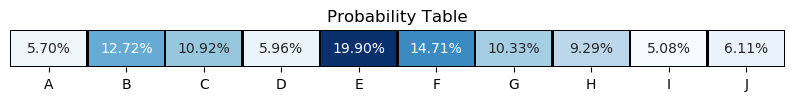

In [4]:
fig, ax = mab.plot(kind='probability-table')
fig.set_size_inches(10, 0.5), fig.set_dpi(100), ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J'])
plt.show()

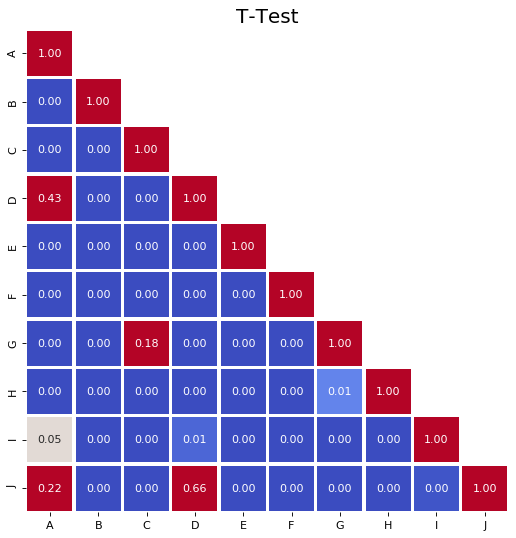

In [5]:
fig, ax = mab.statistics(kind='ttest')
fig.set_size_inches(8, 8), fig.set_dpi(80)
labels = ['A','B','C','D','E','F','G','H','I','J']
ax.set_xticklabels(labels), ax.set_yticklabels(labels)
plt.show()

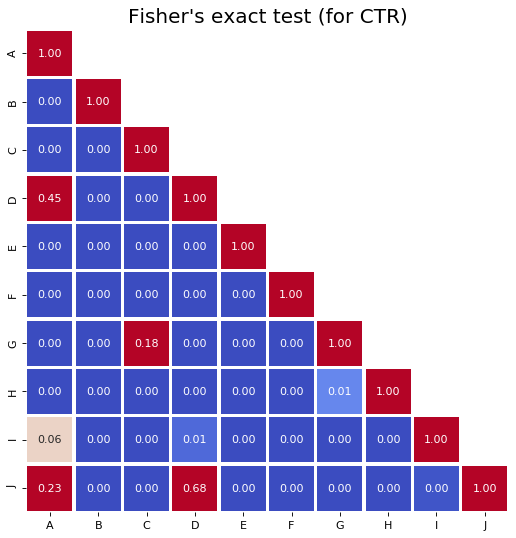

In [6]:
fig, ax = mab.statistics(kind='fisher')
fig.set_size_inches(8, 8), fig.set_dpi(80)
labels = ['A','B','C','D','E','F','G','H','I','J']
ax.set_xticklabels(labels), ax.set_yticklabels(labels)
plt.show()

## Using a standard A/B Testing

In [7]:
mab.reset()
mab.run(algorithm='ab-test')

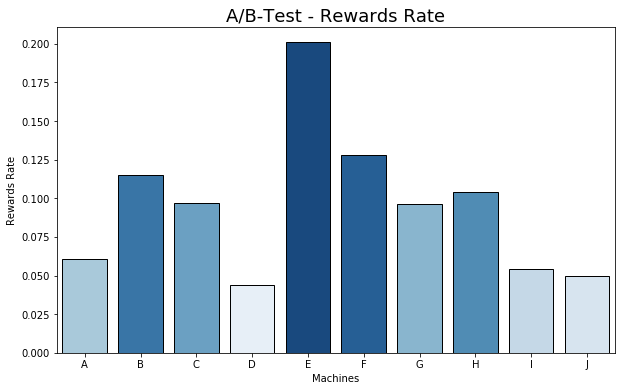

In [8]:
fig, ax = mab.plot(algorithm='ab-test', kind='rewards-rate')
fig.set_size_inches(10, 6), ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J'])
plt.show()

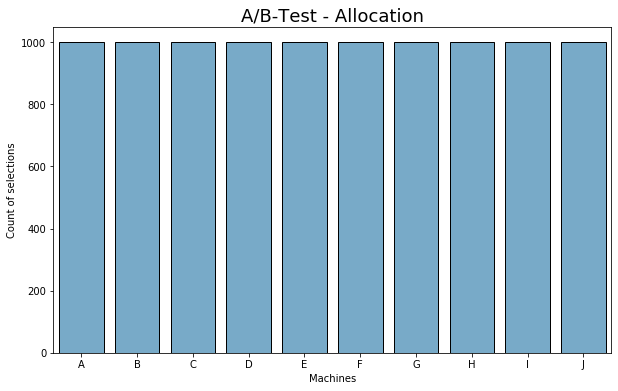

In [9]:
fig, ax = mab.plot(algorithm='ab-test', kind='allocation')
fig.set_size_inches(10, 6), ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J'])
plt.show()

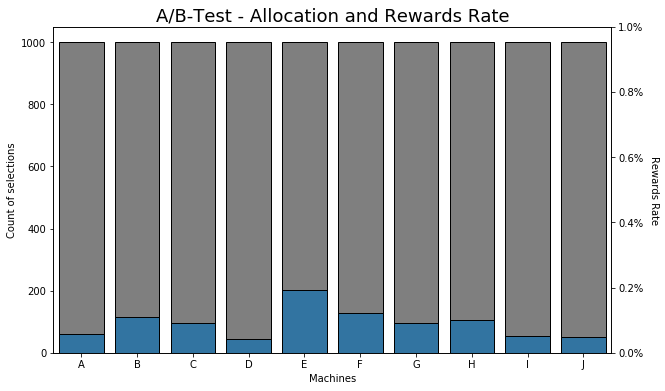

In [10]:
fig, ax = mab.plot(algorithm='ab-test',kind='both')
fig.set_size_inches(10, 6), ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J'])
plt.show()

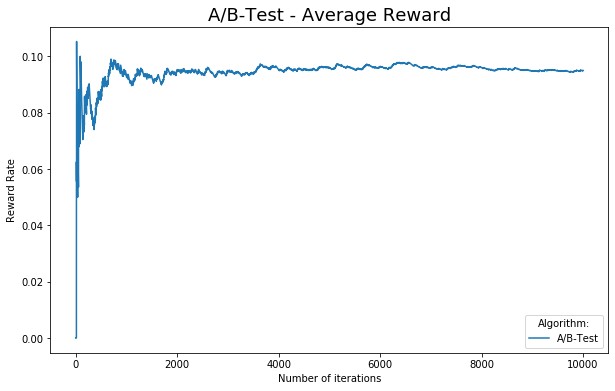

In [11]:
fig, ax = mab.plot(algorithm='ab-test', kind='reward')
fig.set_size_inches(10, 6)

In [12]:
print(f'Total conversions with A/B Testing: {int(sum(mab.arms_reward))}')

Total conversions with A/B Testing: 950


## Using the Upper Confidence Bound algorithm

In [13]:
mab.reset()
mab.run()

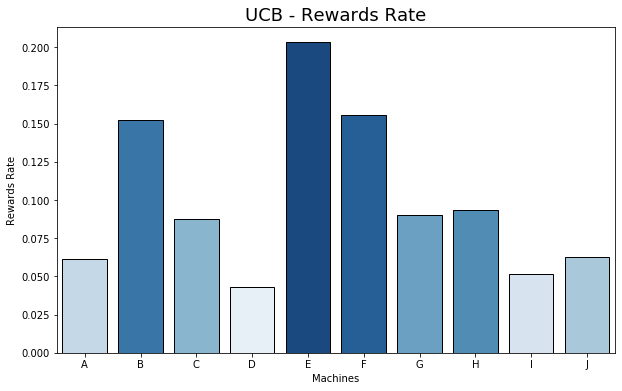

In [14]:
fig, ax = mab.plot(kind='rewards-rate')
fig.set_size_inches(10, 6), ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J'])
plt.show()

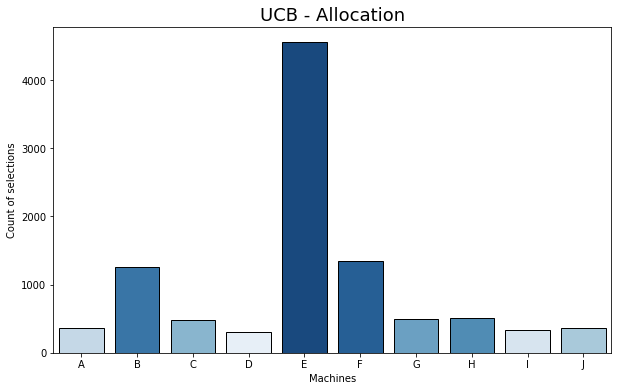

In [15]:
fig, ax = mab.plot(kind='allocation')
fig.set_size_inches(10, 6), ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J'])
plt.show()

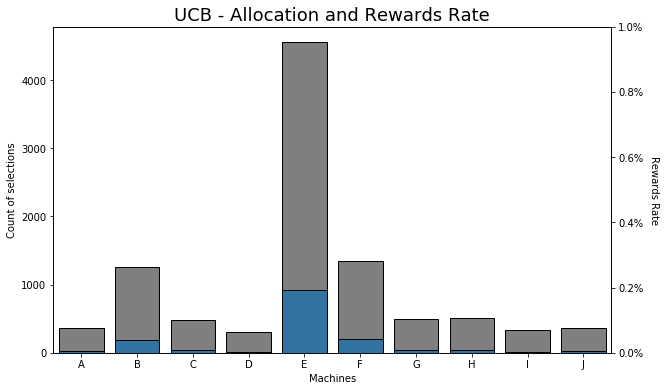

In [16]:
fig, ax = mab.plot(kind='both')
fig.set_size_inches(10, 6), ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J'])
plt.show()

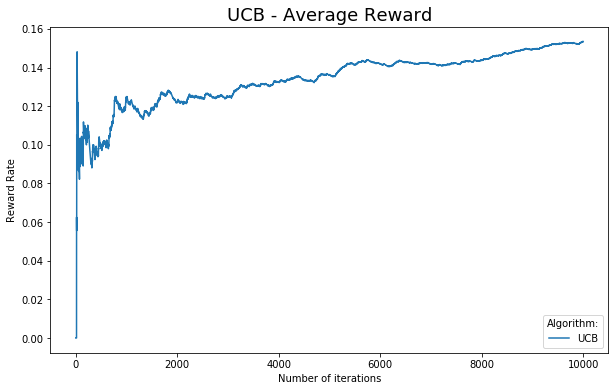

In [17]:
fig, ax = mab.plot(kind='reward')
fig.set_size_inches(10, 6)

In [18]:
print(f'Total conversions with UCB: {int(sum(mab.arms_reward))}!')

Total conversions with UCB: 1535!


### UCB Confidence Interval

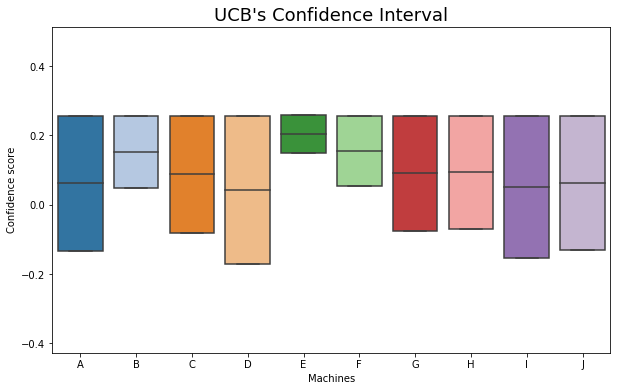

In [19]:
fig, ax = mab.plot(kind='cb')
fig.set_size_inches(10, 6), ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J'])
plt.show()

### Plotting the UCB algorithm process:

install https://imagemagick.org/index.php on your local machine or use !apt install imagemagick for Google Colab environment.

In [20]:
def animate(i):
    if i > 500:
        i = 500 + (i-500)*19

    fig.clear()
    mab.plot(kind='allocation', limit=i, animate=True)
    plt.xticks(range(mab.arms), ['A','B','C','D','E','F','G','H','I','J'])

In [21]:
fig = plt.figure(figsize=(10,6))
animation = FuncAnimation(fig, animate, frames=1000, interval=100)

video = animation.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

In [22]:
def animate(i):
    if i > 500:
        i = 500 + (i-500)*19

    fig.clear()
    mab.plot(kind='cb', limit=i, animate=True)
    plt.xticks(range(mab.arms), ['A','B','C','D','E','F','G','H','I','J'])
    if i <= mab.arms:
        plt.ylim(-4, 4)

In [23]:
fig = plt.figure(figsize=(10,6))

animation = FuncAnimation(fig, animate, frames=1000, interval=100)

video = animation.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

## Using the Thompson Sampling algorithm

In [24]:
mab.reset()
mab.run(algorithm='thompson')

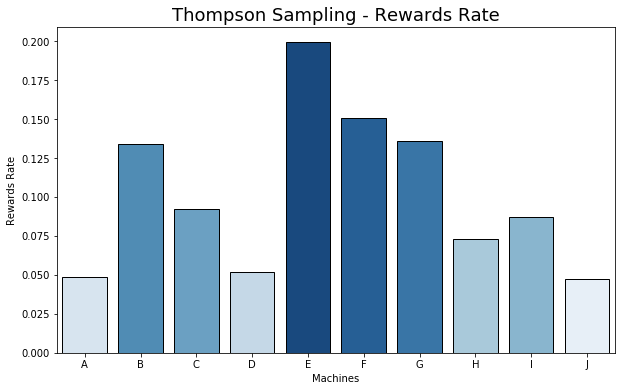

In [25]:
fig, ax = mab.plot(algorithm='thompson', kind='rewards-rate')
fig.set_size_inches(10, 6), ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J'])
plt.show()

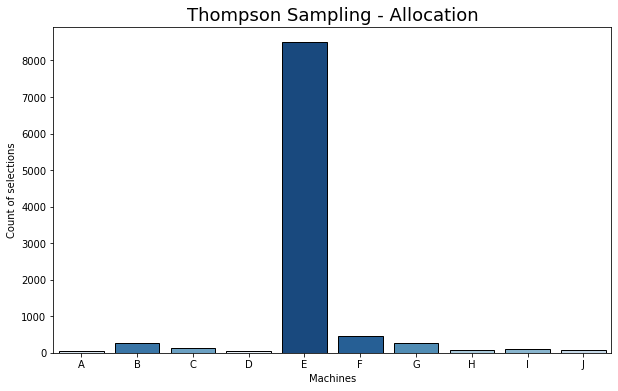

In [26]:
fig, ax = mab.plot(algorithm='thompson', kind='allocation')
fig.set_size_inches(10, 6), ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J'])
plt.show()

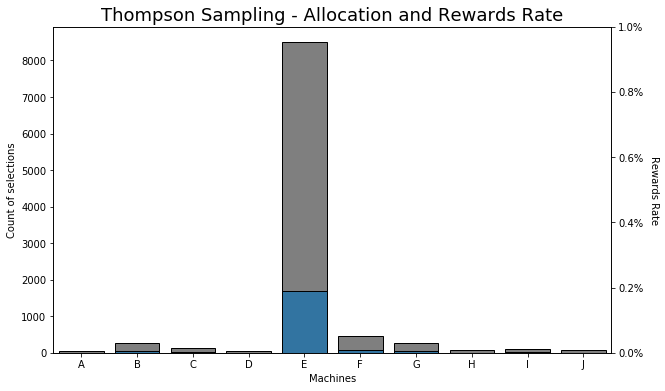

In [27]:
fig, ax = mab.plot(algorithm='thompson', kind='both')
fig.set_size_inches(10, 6), ax.set_xticklabels(['A','B','C','D','E','F','G','H','I','J'])
plt.show()

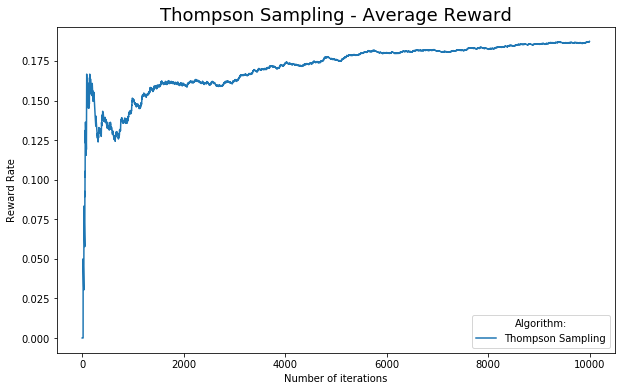

In [28]:
fig, ax = mab.plot(algorithm='thompson', kind='reward')
fig.set_size_inches(10, 6)

In [29]:
print(f'Total conversions with Thompson Sampling: {int(sum(mab.arms_reward))}!!')

Total conversions with Thompson Sampling: 1873!!


### Thompson-greedy

In [30]:
mab.reset()
mab.run(algorithm='thompson', greedy=10)

In [31]:
print(f'Total conversions with Thompson Greedy: {int(sum(mab.arms_reward))}!!')

Total conversions with Thompson Greedy: 1970!!


### Thompson Sampling Beta Distribution

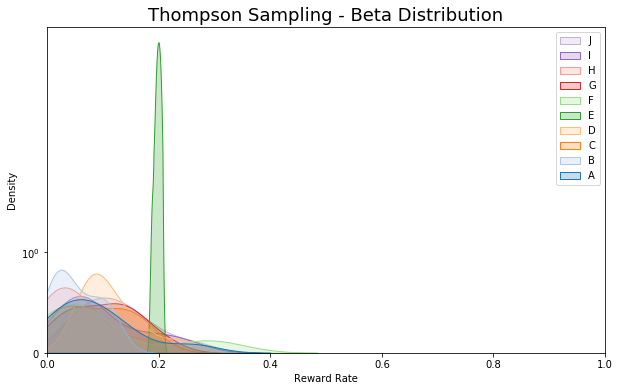

In [32]:
fig, ax = mab.plot(algorithm='thompson', kind='beta')
fig.set_size_inches(10, 6)
plt.yscale("symlog"), ax.legend(['A','B','C','D','E','F','G','H','I','J'][::-1])
plt.show()

Adding Distribution peak-lines

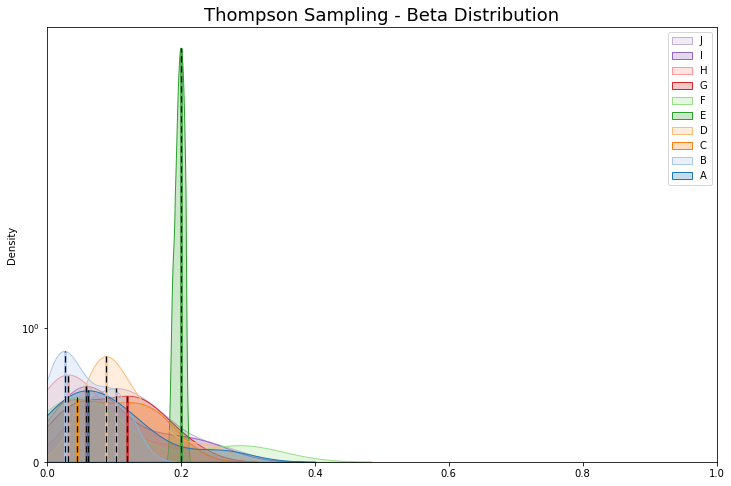

In [33]:
x, y, z = mab.plot(algorithm='thompson', kind='beta', attributes=True)
plt.close()

plt.figure(figsize=(12,8))
plt.title('Thompson Sampling - Beta Distribution', fontsize=18), plt.yscale("symlog"), plt.xlim(0,1)
ax = sns.kdeplot(x=x, hue=y, fill=True, palette='tab20', linewidth=1, alpha=0.25)
ax.legend(['A','B','C','D','E','F','G','H','I','J'][::-1])

for i in range(mab.arms):
    xs = ax.get_children()[i].get_paths()[0].vertices[:, 0]
    ys = ax.get_children()[i].get_paths()[0].vertices[:, 1]
    ax.vlines(xs[np.argmax(ys)], 0, np.max(ys), color=ax.get_children()[i].get_facecolor(), linestyle='-', linewidth=3, alpha=0.75)
    ax.vlines(xs[np.argmax(ys)], 0, np.max(ys), color='black', linestyle=(0, (5, 3)), linewidth=1.25)

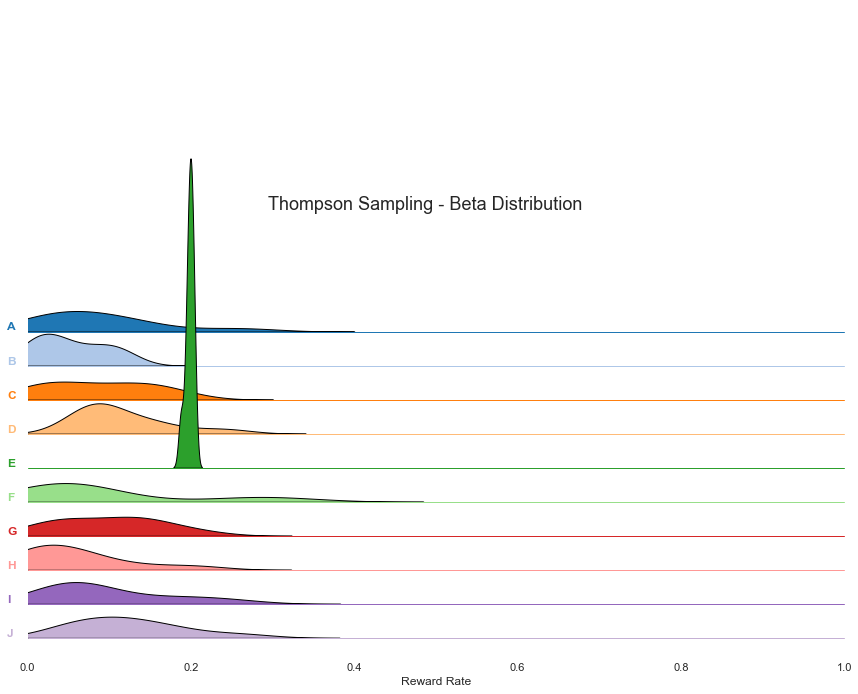

In [34]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = pd.DataFrame(np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1), columns=['values','machines'])
df['machines'] = df['machines'].apply(lambda x: ['A','B','C','D','E','F','G','H','I','J'][int(x)])

g = sns.FacetGrid(df, row="machines", hue="machines", aspect=12, height=1, palette='tab20')

g.map(sns.kdeplot, "values", fill=True, alpha=1, linewidth=1, edgecolor='black')
g.map(plt.axhline, y=0, lw=1, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.025, 0.05, label, fontweight="bold", color=color, ha="left", transform=ax.transAxes)

g.map(label, "values")

g.fig.subplots_adjust(hspace=-0.9)

g.set_xlabels('Reward Rate'), plt.suptitle('Thompson Sampling - Beta Distribution', fontsize=18, y=0.7)
g.set(xlim=(0,1), yticks=[]), g.set_titles(""), g.despine(bottom=True, left=True)
plt.show()

sns.set_style('white')

### Plotting the Thompson Sampling process:

In [35]:
def animate(i):
    if i > 500:
        i = 500 + (i-500)*19

    fig.clear()
    mab.plot(algorithm='thompson' ,kind='allocation', limit=i, animate=True)
    plt.xticks(range(mab.arms), ['A','B','C','D','E','F','G','H','I','J'])

In [36]:
fig = plt.figure(figsize=(10,6))

animation = FuncAnimation(fig, animate, frames=1000, interval=100)

video = animation.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

In [37]:
def animate(i):
    if i > 500:
        i = 500 + (i-500)*19

    fig.clear()
    mab.plot(algorithm='thompson', kind='beta', limit=i, animate=True)
    plt.legend(['A','B','C','D','E','F','G','H','I','J'][::-1])

In [38]:
fig = plt.figure(figsize=(10,6))
animation = FuncAnimation(fig, animate, frames=1000, interval=100)

video = animation.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

## Using Expected-Value assignment

Allocating based on expected value E(x) results in "Make it or break it" situation. Sometimes, the most efficient machine can be ignored this way.

In [39]:
mab.reset()
mab.run(algorithm='expected-value')

In [40]:
print(f'Total conversions with Expected-Value: {int(sum(mab.arms_reward))}!!')

Total conversions with Expected-Value: 1942!!


## Comparing the Algorithms:

In [41]:
mab.reset(), mab.run(algorithm='ab-test')
x1, y1, z1 = mab.plot(algorithm='ab-test', kind='reward', attributes=True)
plt.close()
mab.reset(), mab.run(algorithm='ucb')
x2, y2, z2 = mab.plot(algorithm='ucb', kind='reward', attributes=True)
plt.close()
mab.reset(), mab.run(algorithm='thompson')
x3, y3, z3 = mab.plot(algorithm='thompson', kind='reward', attributes=True)
plt.close()
mab.reset(), mab.run(algorithm='thompson', greedy=15)
x4, y4, z4 = mab.plot(algorithm='thompson', kind='reward', attributes=True)
plt.close()
mab.reset(), mab.run(algorithm='expected-value')
x5, y5, z5 = mab.plot(algorithm='expected-value', kind='reward', attributes=True)
plt.close()

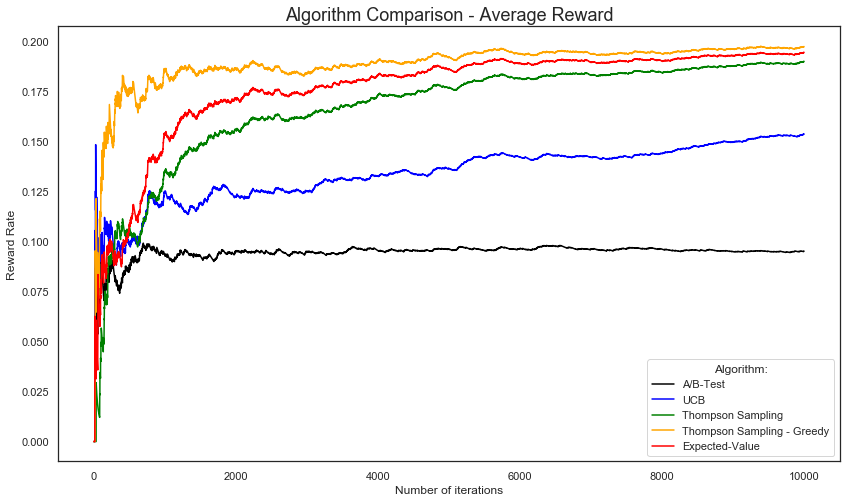

In [42]:
plt.figure(figsize=(14,8))
sns.lineplot(x=x1, y=y1, label='A/B-Test', color='black')
sns.lineplot(x=x2, y=y2, label='UCB', color='blue')
sns.lineplot(x=x3, y=y3, label='Thompson Sampling', color='green')
sns.lineplot(x=x4, y=y4, label='Thompson Sampling - Greedy', color='orange')
sns.lineplot(x=x5, y=y5, label='Expected-Value', color='red')
plt.title('Algorithm Comparison - Average Reward', fontsize=18), plt.xlabel('Number of iterations'), plt.ylabel('Reward Rate')
plt.legend(loc='lower right', title='Algorithm:')
plt.show()